In [82]:
import jax
from jax import random, grad, jit, vmap
from jax.config import config
import jax.numpy as np
from jax.experimental import optimizers, stax
from livelossplot import PlotLosses
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm as tqdm
import os
import imageio
# from tqdm.notebook import tqdm as tqdm
from tqdm import tqdm
import numpy as onp
import pdb
from PIL import Image
from jax.nn.initializers import glorot_normal, normal, ones, zeros

def output_layer():
    init_fun = lambda rng, input_shape: (input_shape, ())
    def apply_fun(params, inputs, **kwargs):
        outputs = np.stack([jax.nn.relu(inputs[..., 0]), jax.nn.sigmoid(inputs[..., 1]) * np.pi*2], -1)
        return outputs
    
    return init_fun, apply_fun
    

def make_network(num_layers, num_channels):
    layers = []
    for i in range(num_layers-1):
        layers.append(stax.Dense(num_channels))
        layers.append(stax.Relu)
    layers.append(stax.Dense(2))
    layers.append(output_layer())
    return stax.serial(*layers)

model_loss = jit(lambda params, x, y: .5 * np.mean((apply_fn(params, x) - y) ** 2))

model_psnr = jit(lambda params, x, y: -10 * np.log10(2.*model_loss(params, x, y)))
model_grad_loss = jit(lambda params, x, y: jax.grad(model_loss)(params, x, y))
input_encoder = jit(lambda x, a, b: np.concatenate([a * np.sin((2.*np.pi*x) @ b.T), 
                                                    a * np.cos((2.*np.pi*x) @ b.T)], axis=-1))

def train_model(lr, iters, train_data, test_data, name='test', plot_groups=None):
    opt_init, opt_update, get_params = optimizers.adam(lr)
    opt_update = jit(opt_update)

    _, params = init_fn(rand_key, (-1, train_data[0].shape[-1]))
    opt_state = opt_init(params)

    train_psnrs = []
    test_psnrs = []
    train_loss = []
    test_loss = []
    xs = []
    if plot_groups is not None:
        plot_groups['Test PSNR'].append(f'{name}_test')
        plot_groups['Train PSNR'].append(f'{name}_train')
    for i in tqdm(range(iters), desc='train iter', leave=False):
        opt_state = opt_update(i, model_grad_loss(get_params(opt_state), *train_data), opt_state)
        if i % 25 == 0:
            train_psnr = model_psnr(get_params(opt_state), *train_data)
            test_psnr = model_psnr(get_params(opt_state), *test_data)
            train_psnrs.append(train_psnr)
            test_psnrs.append(test_psnr)
            train_loss.append(model_loss(get_params(opt_state), *train_data))
            test_loss.append(model_loss(get_params(opt_state), *test_data))
            xs.append(i)
            if plot_groups is not None:
                plotlosses_model.update({f'{name}_train':train_psnr, f'{name}_test':test_psnr}, current_step=i)
        if i % 100 == 0 and i != 0 and plot_groups is not None:
            plotlosses_model.send()
    if plot_groups is not None:
        plotlosses_model.send()
    results = {
        'state': get_params(opt_state),
        'train_psnrs': train_psnrs,
        'test_psnrs': test_psnrs,
        'xs': xs
    }
    return results

In [83]:
## Random seed
def plot(R):
    clim = np.quantile(np.abs(R.reshape(-1)), np.array([.01, .99]))
    plt.imshow(np.abs(R), vmin=clim[0], vmax=clim[1])

rand_key = random.PRNGKey(10)
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']
data = np.array(Image.open('MRI.bmp'))[..., None] / 255
def FFT2(inputs):
    raw_fft = np.fft.fft2(inputs.reshape(inputs.shape[:2]))  
    phasor = np.angle(raw_fft) + np.pi
    mag = np.abs(raw_fft) / np.abs(raw_fft).max()
    return np.stack([mag, phasor], axis=-1)

def IFFT2(inputs):
    mag = inputs[..., 0]
    phasor = inputs[..., 1] - np.pi
    raw_fft = mag * np.cos(phasor) + 1j *mag * np.sin(phasor)
    raw_fft = raw_fft[..., None]
    return np.fft.ifft2(raw_fft)

# training 

In [84]:
# plt_groups = {'Test PSNR':[], 'Train PSNR':[], 'Train Loss':[], 'Test Loss':[]}
plt_groups = {'Test PSNR':[], 'Train PSNR':[]}
plotlosses_model = PlotLosses(groups=plt_groups)

network_depth =  4#@param
network_width = 256 #@param
lr =  1e-3#@param
training_steps =  4000#@param
test_scales =  [13,14,15]#@param
embedding_size =  256#@param
init_fn, apply_fn = make_network(network_depth, network_width)

y_train = data
x1 = np.fft.fftfreq(data.shape[0]//2)
# x1 = np.linspace(0, 1, data.shape[0]//2+1)[:-1]
x_train = np.stack(np.meshgrid(x1,x1), axis=-1)
# x1_t = np.linspace(0, 1, data.shape[0]+1)[:-1]
x1_t = np.fft.fftfreq(data.shape[0])
x_test = np.stack(np.meshgrid(x1_t,x1_t), axis=-1)
bvals = random.normal(rand_key, (embedding_size, 2))
avals = np.ones((bvals.shape[0]))
scale = 100
train_data = (input_encoder(x_train, avals, bvals*scale), y_train[::2,::2,:])
test_data = (input_encoder(x_test, avals, bvals*scale), y_train)
# train_data = (input_encoder(x_train, avals, bvals*scale), FFT2(y_train[::2,::2,:]))
# test_data = (input_encoder(x_test[1::2,1::2], avals, bvals*scale), FFT2(y_train[1::2,1::2,:]))
    
# train_data = (x_train, FFT2(y_train[::2,::2,:]))
# test_data = (x_test[1::2, 1::2], FFT2(y_train[1::2, 1::2, :]))


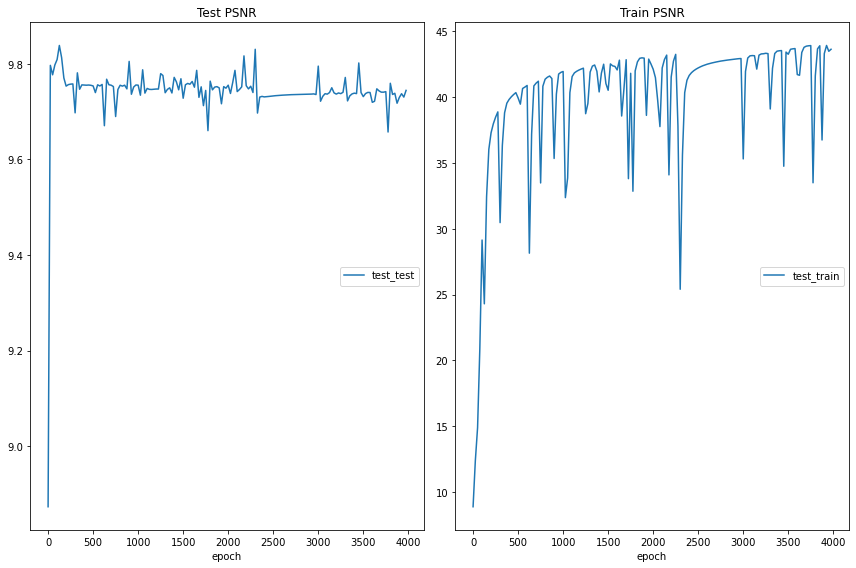

Test PSNR
	test_test        	 (min:    8.874, max:    9.838, cur:    9.744)
Train PSNR
	test_train       	 (min:    8.866, max:   43.933, cur:   43.645)


In [85]:
# train_data = ((x_train), y_train[::2,::2,:])
# test_data = ((x_test), y_train)
# train_data = (input_encoder(x_train, avals, bvals*scale), y_train[::2,::2,:])
# test_data = (input_encoder(x_test[1::2,1::2], avals, bvals*scale), y_train[1::2,1::2,:])
# (x_train @ bvals.T).shape
# np.fft.fftfreq(data.shape[0]//2)
model_loss = jit(lambda params, x, y: .5 * np.mean((np.abs(IFFT2(apply_fn(params, x))) - y) ** 2))
results = train_model(lr, training_steps, train_data, test_data, name='test', plot_groups=plt_groups)

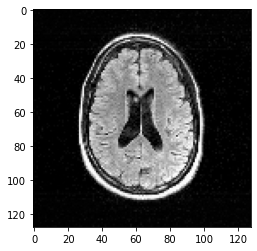

In [74]:
# test_data = (input_encoder(x_train, avals, bvals*scale), )
test_input = onp.array(train_data[0])
test = apply_fn(results['state'], test_input)
test = IFFT2(test)
test = onp.array(test)
test.shape
plt.imshow(np.abs(test))
# np.fft.fftfreq(data.shape[0])
# plt.imshow(np.abs(IFFT2(test)))
# 1/ data.shape[0]
# plt.imshow(np.abs(IFFT2(np.abs(train_data[1]))))
# plt.imshow(np.abs(IFFT2(np.exp(1j*np.angle(train_data[1])))))
# plt.imshow(np.abs(test - train_data[1])[..., 0], cmap='jet')
# plt.colorbar()
# plt.imshow(np.abs(IFFT2(test)))
# plt.imshow(np.abs(IFFT2(test)))
# plt.colorbar()
# plt.imshow(np.abs(IFFT2(FFT2(data))))
# FFT2(y_train[::2,::2,:]).shape
# real = test_fft[..., 0] * np.cos(test_fft[..., 1] - np.pi)
# imag = test_fft[..., 0] * np.sin(test_fft[..., 1] - np.pi)
# raw_fft.imag
# (test_fft[..., 1] - np.pi).min()
# np.abs(((test_fft[..., 1] - np.pi) - np.angle(raw_fft))).mean()

DeviceArray([ 0.        ,  0.03333334,  0.06666667,  0.10000001,
              0.13333334,  0.16666667,  0.20000002,  0.23333335,
              0.26666668,  0.3       ,  0.33333334,  0.36666667,
              0.40000004,  0.43333337,  0.4666667 , -0.5       ,
             -0.4666667 , -0.43333337, -0.40000004, -0.36666667,
             -0.33333334, -0.3       , -0.26666668, -0.23333335,
             -0.20000002, -0.16666667, -0.13333334, -0.10000001,
             -0.06666667, -0.03333334], dtype=float32)

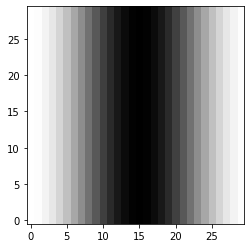

In [75]:
mag = onp.zeros((30,30))   # magnitude (all zeros for now)
ph  = onp.zeros((30,30))   # phase (all zeros for now)

mag[1,0] = 1                # 1 cycle in x, 0 cycles in y

y = mag*onp.exp(1j*ph)           # build fft combining magnitude and phase
x = onp.real(np.fft.ifft2(y))    # inverse fft (then take real part)
plt.imshow(x.T,origin='lower')                   # plot
np.fft.fftfreq(mag.shape[0])

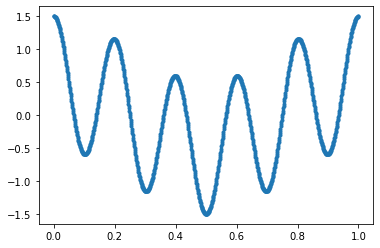

In [76]:
freq1 = 5.0      # freq in Hz
freq2 = 1.0      # freq in Hz
samp  = 1000.0   # sampling rate in Hz

t = np.arange(0,1,1/samp)  # time (1s of data)
N = len(t)                 # store the number of time points

x = np.cos(2*np.pi*freq1*t) + .5*np.cos(2*np.pi*freq2*t)    # the signal equation
plt.plot(t,x,'.-')
  

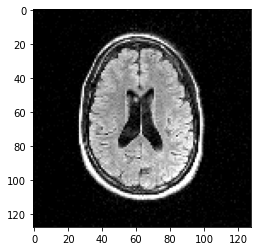

In [77]:
im = np.array(Image.open('MRI.bmp'))[..., None] / 255
x  = im[::2,::2, 0]
plt.imshow(x)
plt.show()

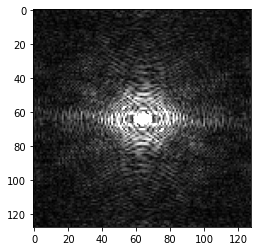

In [78]:
y  = np.fft.fft2(x)
clim = np.quantile(np.abs(y.reshape(-1)), np.array([.01, .99]))
plt.imshow(np.fft.fftshift(np.abs(y)), vmin=clim[0], vmax=clim[1])
plt.gray()
plt.show()

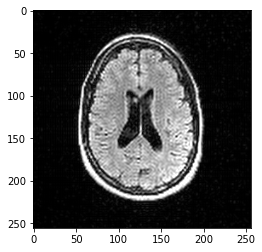

In [79]:
y = np.fft.fftshift(y)         # we need this before zero padding
z = np.fft.ifft2(y, s=im.shape[:2]) # zero padded ifft
clim = np.quantile(np.abs(z.reshape(-1)), np.array([.01, .99]))
plt.imshow(np.abs(z), vmin=clim[0], vmax=clim[1])
plt.show()

In [81]:
# def my_fft2(data):    
# ifft 
M = np.fft.fftfreq(data.shape[0])
N = np.fft.fftfreq(data.shape[1])
u = np.stack(np.meshgrid(M, N), axis=-1)
Fu = y
# compute one pixel
np.fft.fftfreq(10)


DeviceArray([ 0. ,  0.1,  0.2,  0.3,  0.4, -0.5, -0.4, -0.3, -0.2, -0.1],            dtype=float32)